# ML Pipeline de Operaciones en Earthquake para Predecir Total Damages con GradientBoosterClassifier

## Versión 2 o Test B
Diferencia respecto a original: Este aplica filtro > 0 para excluir filas con valores 0 en 'Dis Mag Value', 'Total Deaths', 'Total Affected' y 'Total Damages Adj'

## Objetivos

### Predecir Total Damages (y numérica) a partir de X con features numéricas.

Agrupar múltiples operaciones en un mismo objeto:

* Borrar columnas, imputar valores faltantes
* Preprocessing: Umbrales y función estadística para determinar niveles de bajo a muy alto a imputar en columna categórica Earthquake Type.
* OneHotEncoder para pasar de columna categórica Earthquake Type a numérica Total Damages Adj.
* Pipeline:
    + Imputar most_frequent a nulos con SimpleImputer
    + Escalar características numéricas
    + RandomForestRegressor
* Modelado para predecir Total Damages Adj

## Importar librerías

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Split X train y test
from sklearn.model_selection import train_test_split

# Modelos para validación cruzada con cross_val_score y cross_validate
from sklearn.ensemble import RandomForestRegressor # Elegido
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Modelos para validar por regresión
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor

# Validación de modelos:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Calificación de modelos
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import make_scorer
from sklearn.metrics import SCORERS

# Para imputación categórica a numérica y predicción de columna numérica Total Damages Adj en Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor

# Convertir columnas categóricas (Disaster Subtype, Origin, Associated Disaster) a numéricas para predecir Total Damages Adj Dis o Mag Value
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

# Pipeline
from sklearn.pipeline import Pipeline
import joblib # guardar pipeline

## Cargar datos

In [46]:
df = pd.read_csv('../../../Data/03Limpio/03desastreslimpio.csv')
df.head(10)

,Dis No,Year,Seq,Disaster Subgroup,Disaster Type,Disaster Subtype,Country,ISO,Region,Continent,...,Longitude,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj
0,1900-9002-CPV,1900,9002,Climatological,Drought,Drought,Cabo Verde,CPV,Western Africa,Africa,...,NaN,1900,0,0,1900,0,0,11000,0,0
1,1900-9001-IND,1900,9001,Climatological,Drought,Drought,India,IND,Southern Asia,Asia,...,NaN,1900,0,0,1900,0,0,1250000,0,0
2,1902-0012-GTM,1902,12,Geophysical,Earthquake,Ground movement,Guatemala,GTM,Central America,Americas,...,-91,1902,4,18,1902,4,18,2000,0,843726
3,1902-0003-GTM,1902,3,Geophysical,Volcanic activity,Ash fall,Guatemala,GTM,Central America,Americas,...,NaN,1902,4,8,1902,4,8,1000,0,0
4,1902-0010-GTM,1902,10,Geophysical,Volcanic activity,Ash fall,Guatemala,GTM,Central America,Americas,...,NaN,1902,10,24,1902,10,24,6000,0,0
5,1903-0006-CAN,1903,6,Geophysical,Mass movement (dry),Rockfall,Canada,CAN,Northern America,Americas,...,NaN,1903,4,29,1903,4,29,76,23,0
6,1903-0012-COM,1903,12,Geophysical,Volcanic activity,Ash fall,Comoros (the),COM,Eastern Africa,Africa,...,NaN,1903,0,0,1903,0,0,17,0,0
7,1904-0003-BGD,1904,3,Meteorological,Storm,Tropical cyclone,Bangladesh,BGD,Southern Asia,Asia,...,NaN,1904,11,0,1904,11,0,0,0,0
8,1905-0005-CAN,1905,5,Geophysical,Mass movement (dry),Rockfall,Canada,CAN,Northern America,Americas,...,NaN,1905,8,13,1905,8,13,18,18,0
9,1905-0003-IND,1905,3,Geophysical,Earthquake,Ground movement,India,IND,Southern Asia,Asia,...,76.16,1905,4,4,1905,4,4,20000,0,812477


## Comprobación Básica df

In [47]:
df.shape

(16636, 26)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16636 entries, 0 to 16635
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Dis No             16636 non-null  object
 1   Year               16636 non-null  int64 
 2   Seq                16636 non-null  int64 
 3   Disaster Subgroup  16636 non-null  object
 4   Disaster Type      16636 non-null  object
 5   Disaster Subtype   13313 non-null  object
 6   Country            16636 non-null  object
 7   ISO                16636 non-null  object
 8   Region             16636 non-null  object
 9   Continent          16636 non-null  object
 10  Location           14825 non-null  object
 11  Origin             4085 non-null   object
 12  Associated Dis     3593 non-null   object
 13  Dis Mag Value      16636 non-null  int64 
 14  Dis Mag Scale      15416 non-null  object
 15  Latitude           2775 non-null   object
 16  Longitude          2775 non-null   objec

In [49]:
df.columns

Index(['Dis No', 'Year', 'Seq', 'Disaster Subgroup', 'Disaster Type',
       'Disaster Subtype', 'Country', 'ISO', 'Region', 'Continent', 'Location',
       'Origin', 'Associated Dis', 'Dis Mag Value', 'Dis Mag Scale',
       'Latitude', 'Longitude', 'Start Year', 'Start Month', 'Start Day',
       'End Year', 'End Month', 'End Day', 'Total Deaths', 'Total Affected',
       'Total Damages Adj'],
      dtype='object')

In [50]:
print(df.isnull().sum())
print(df.isna().sum())

Dis No                   0
Year                     0
Seq                      0
Disaster Subgroup        0
Disaster Type            0
Disaster Subtype      3323
Country                  0
ISO                      0
Region                   0
Continent                0
Location              1811
Origin               12551
Associated Dis       13043
Dis Mag Value            0
Dis Mag Scale         1220
Latitude             13861
Longitude            13861
Start Year               0
Start Month              0
Start Day                0
End Year                 0
End Month                0
End Day                  0
Total Deaths             0
Total Affected           0
Total Damages Adj        0
dtype: int64
Dis No                   0
Year                     0
Seq                      0
Disaster Subgroup        0
Disaster Type            0
Disaster Subtype      3323
Country                  0
ISO                      0
Region                   0
Continent                0
Location       

# Preparación de dataset

### Filtro Earthquake

In [51]:
# Filtro principal para Earthquake
df_earthquake = df[df['Disaster Type'] == 'Earthquake']

### Limpieza

#### Borrar columnas

In [52]:
df_earthquake.drop(columns=['Dis No', 'Year', 'Seq', 'Disaster Subgroup', 'ISO', 'Latitude', 'Longitude', 'Origin', 'Associated Dis'], inplace=True)

C:\Users\AleEng\AppData\Local\Temp\ipykernel_19392\1705216719.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_earthquake.drop(columns=['Dis No', 'Year', 'Seq', 'Disaster Subgroup', 'ISO', 'Latitude', 'Longitude', 'Origin', 'Associated Dis'], inplace=True)


In [53]:
df_earthquake.head(2)

,Disaster Type,Disaster Subtype,Country,Region,Continent,Location,Dis Mag Value,Dis Mag Scale,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj
2,Earthquake,Ground movement,Guatemala,Central America,Americas,"Quezaltenango, San Marcos",8,Richter,1902,4,18,1902,4,18,2000,0,843726
9,Earthquake,Ground movement,India,Southern Asia,Asia,Kangra,8,Richter,1905,4,4,1905,4,4,20000,0,812477


### Valores faltantes

In [54]:
# # Rellenar valores faltantes y nulls con 0, después, borrar filas con valores faltantes
# df_earthquake = df_earthquake.copy()
# df_earthquake.fillna(0, inplace=True)

## Preprocessing

## Preprocessing

### Filtro para excluir filas con valores 0 en 'Dis Mag Value', 'Total Deaths', 'Total Affected' y 'Total Damages Adj'

In [55]:
df_earthquake = df[(df['Dis Mag Value'] > 0) & 
                 (df['Total Deaths'] > 0) & 
                 (df['Total Affected'] > 0) & 
                 (df['Total Damages Adj'] > 0)]

In [56]:
df_earthquake['Dis Mag Value'].min()

1

In [57]:
df_earthquake.shape

(1727, 26)

### Condiciones estadísticas para determinar umbrales de clasificación para Tipo de Inundación y su Daños Totales

In [58]:
min_dis_mag = df_earthquake['Dis Mag Value'].loc[df_earthquake['Dis Mag Value'].gt(0)].min()
max_dis_mag = df_earthquake['Dis Mag Value'].loc[df_earthquake['Dis Mag Value'].gt(0)].max()
std_dis_mag = df_earthquake['Dis Mag Value'].loc[df_earthquake['Dis Mag Value'].gt(0)].std()
mean_dis_mag = df_earthquake['Dis Mag Value'].loc[df_earthquake['Dis Mag Value'].gt(0)].mean()
median_dis_mag = df_earthquake['Dis Mag Value'].loc[df_earthquake['Dis Mag Value'].gt(0)].median()

min_tot_deaths = df_earthquake['Total Deaths'].loc[df_earthquake['Total Deaths'].gt(0)].min()
max_tot_deaths = df_earthquake['Total Deaths'].loc[df_earthquake['Total Deaths'].gt(0)].max()
std_tot_deaths = df_earthquake['Total Deaths'].loc[df_earthquake['Total Deaths'].gt(0)].std()
mean_tot_deaths = df_earthquake['Total Deaths'].loc[df_earthquake['Total Deaths'].gt(0)].mean()
median_tot_deaths = df_earthquake['Total Deaths'].loc[df_earthquake['Total Deaths'].gt(0)].median()

min_tot_affect = df_earthquake['Total Affected'].loc[df_earthquake['Total Affected'].gt(0)].min()
max_tot_affect = df_earthquake['Total Affected'].loc[df_earthquake['Total Affected'].gt(0)].max()
std_tot_affect = df_earthquake['Total Affected'].loc[df_earthquake['Total Affected'].gt(0)].std()
mean_tot_affect = df_earthquake['Total Affected'].loc[df_earthquake['Total Affected'].gt(0)].mean()
median_tot_affect = df_earthquake['Total Affected'].loc[df_earthquake['Total Affected'].gt(0)].median()

min_tot_damages = df_earthquake['Total Damages Adj'].loc[df_earthquake['Total Damages Adj'].gt(0)].min()
max_tot_damages = df_earthquake['Total Damages Adj'].loc[df_earthquake['Total Damages Adj'].gt(0)].max()
std_tot_damages = df_earthquake['Total Damages Adj'].loc[df_earthquake['Total Damages Adj'].gt(0)].std()
mean_tot_damages = df_earthquake['Total Damages Adj'].loc[df_earthquake['Total Damages Adj'].gt(0)].mean()
median_tot_damages = df_earthquake['Total Damages Adj'].loc[df_earthquake['Total Damages Adj'].gt(0)].median()

In [59]:
print(df_earthquake['Dis Mag Value'].loc[df_earthquake['Dis Mag Value'].gt(0)].min())
print(df_earthquake['Dis Mag Value'].loc[df_earthquake['Dis Mag Value'].gt(0)].max())
print(df_earthquake['Dis Mag Value'].loc[df_earthquake['Dis Mag Value'].gt(0)].std())
print(df_earthquake['Dis Mag Value'].loc[df_earthquake['Dis Mag Value'].gt(0)].mean())
print(df_earthquake['Dis Mag Value'].loc[df_earthquake['Dis Mag Value'].gt(0)].median())

print(df_earthquake['Total Deaths'].loc[df_earthquake['Total Deaths'].gt(0)].min())
print(df_earthquake['Total Deaths'].loc[df_earthquake['Total Deaths'].gt(0)].max())
print(df_earthquake['Total Deaths'].loc[df_earthquake['Total Deaths'].gt(0)].std())
print(df_earthquake['Total Deaths'].loc[df_earthquake['Total Deaths'].gt(0)].mean())
print(df_earthquake['Total Deaths'].loc[df_earthquake['Total Deaths'].gt(0)].median())

print(df_earthquake['Total Affected'].loc[df_earthquake['Total Affected'].gt(0)].min())
print(df_earthquake['Total Affected'].loc[df_earthquake['Total Affected'].gt(0)].max())
print(df_earthquake['Total Affected'].loc[df_earthquake['Total Affected'].gt(0)].std())
print(df_earthquake['Total Affected'].loc[df_earthquake['Total Affected'].gt(0)].mean())
print(df_earthquake['Total Affected'].loc[df_earthquake['Total Affected'].gt(0)].median())

print(df_earthquake['Total Damages Adj'].loc[df_earthquake['Total Damages Adj'].gt(0)].min())
print(df_earthquake['Total Damages Adj'].loc[df_earthquake['Total Damages Adj'].gt(0)].max())
print(df_earthquake['Total Damages Adj'].loc[df_earthquake['Total Damages Adj'].gt(0)].std())
print(df_earthquake['Total Damages Adj'].loc[df_earthquake['Total Damages Adj'].gt(0)].mean())
print(df_earthquake['Total Damages Adj'].loc[df_earthquake['Total Damages Adj'].gt(0)].median())

1
2857000
173961.97483786722
47611.13607411696
210.0
1
242000
11460.354803714767
1235.348002316155
23.0
2
238973000
9656036.828331122
1480856.2733063116
36900.0
2
273218373
11529641.319038434
2140629.5645628255
146323.0


### Codificación categórica a numérica

#### Imputación de nulos en columna salida (y) Total Damages Adj con Simple Imputer

In [60]:
# Imputar nulos en la columna de salida (y) que es Total Damages Adj
df_earthquake['Total Damages Adj'] = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(df_earthquake[['Total Damages Adj']])
df_earthquake['Total Damages Adj']
# borrar en lugar de imputar
# df = df.dropna('Total Damages Adj')

C:\Users\AleEng\AppData\Local\Temp\ipykernel_19392\2993419773.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_earthquake['Total Damages Adj'] = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(df_earthquake[['Total Damages Adj']])


64         139559
135      19312844
151       1687452
158       1658743
184        245448
           ...   
16495       56946
16524       50000
16527       50000
16537      250000
16539     1000000
Name: Total Damages Adj, Length: 1727, dtype: int64

In [61]:
df_earthquake['Total Damages Adj'].isna().sum()
# df_earthquake['Total Damages Adj'].unique()
# len(df_earthquake['Total Damages Adj'])

0

### EDA Visualizaciones de 'Total Damages Adj' o Daños Totales

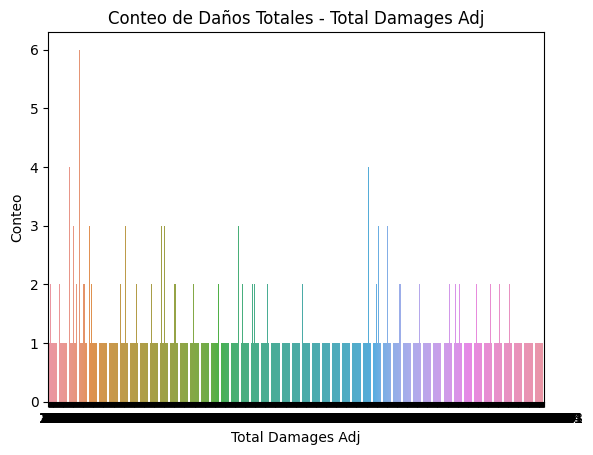

In [62]:
sns.countplot(data=df_earthquake, x='Total Damages Adj')
plt.title('Conteo de Daños Totales - Total Damages Adj')
plt.xlabel('Total Damages Adj')
plt.ylabel('Conteo')
plt.show()

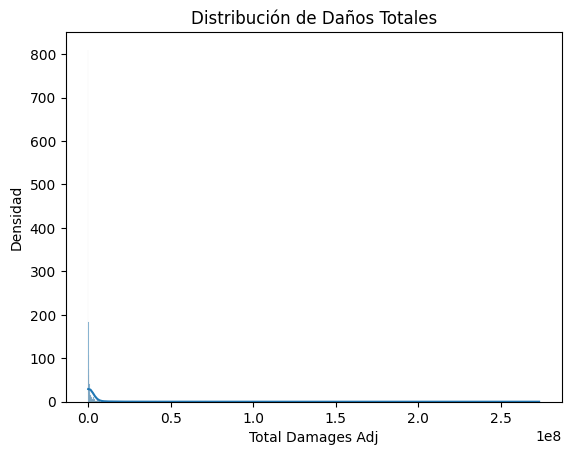

In [63]:
sns.histplot(data=df_earthquake, x='Total Damages Adj', kde=True)
plt.title(f'Distribución de Daños Totales')
plt.xlabel('Total Damages Adj')
plt.ylabel('Densidad')
plt.show()

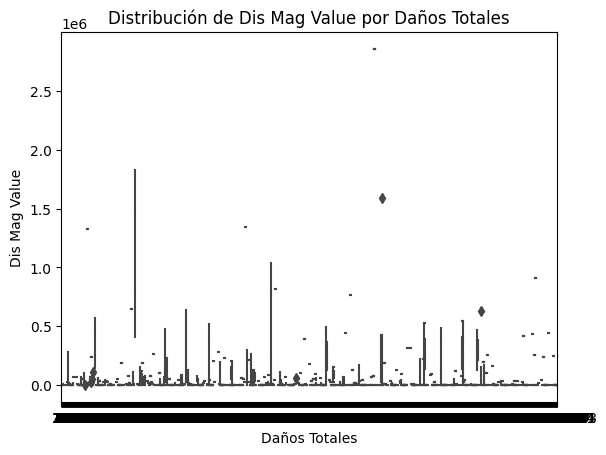

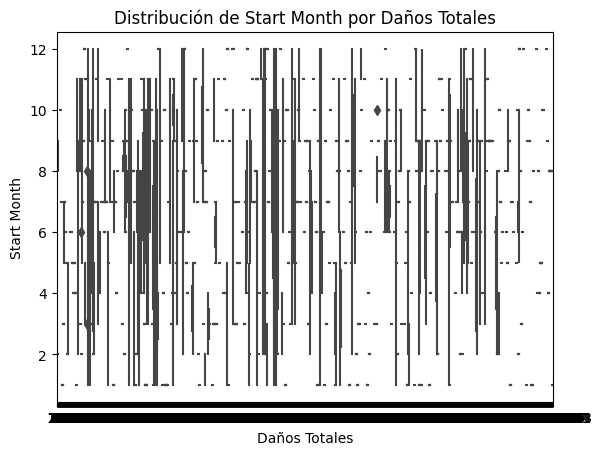

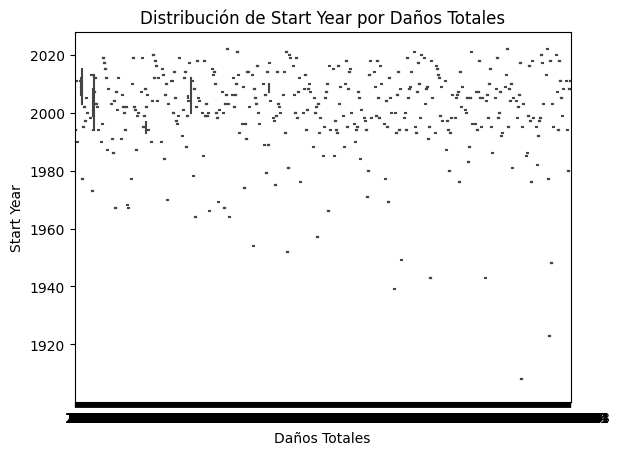

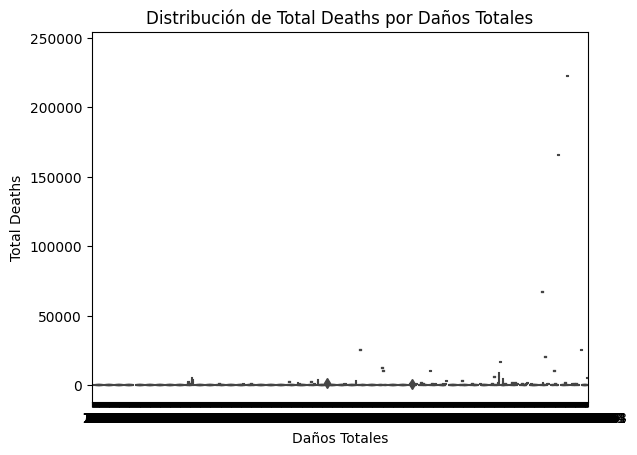

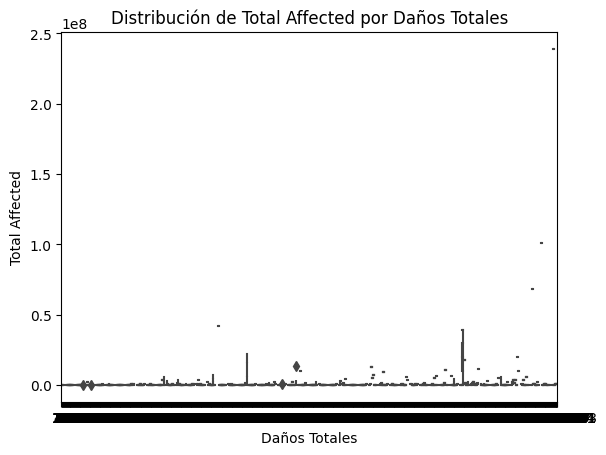

In [64]:
num_cols = ['Dis Mag Value', 'Start Month', 'Start Year', 'Total Deaths', 'Total Affected']
for col in num_cols:
    sns.boxplot(data=df_earthquake, x='Total Damages Adj', y=col)
    plt.title(f'Distribución de {col} por Daños Totales')
    plt.xlabel('Daños Totales')
    plt.ylabel(col)
    plt.show()

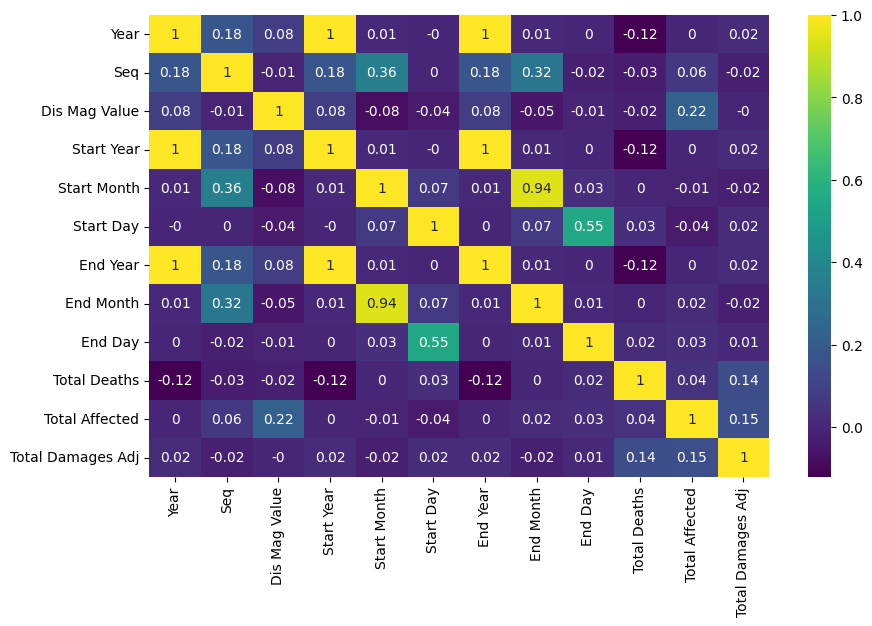

In [65]:
plt.figure(figsize=(10, 6))
df_corr = df_earthquake.corr(numeric_only=True).round(2)
sns.heatmap(df_corr, cmap='viridis', annot=True);

<Axes: xlabel='Dis Mag Value', ylabel='Total Damages Adj'>

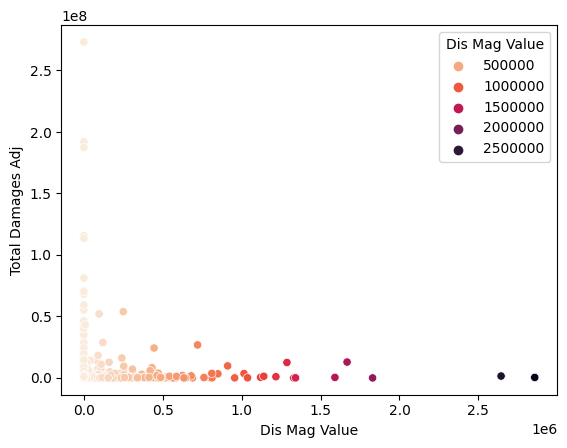

In [66]:
sns.scatterplot(data=df_earthquake, x='Dis Mag Value', y='Total Damages Adj', hue='Dis Mag Value', palette='rocket_r')

<Axes: xlabel='Start Month', ylabel='Total Damages Adj'>

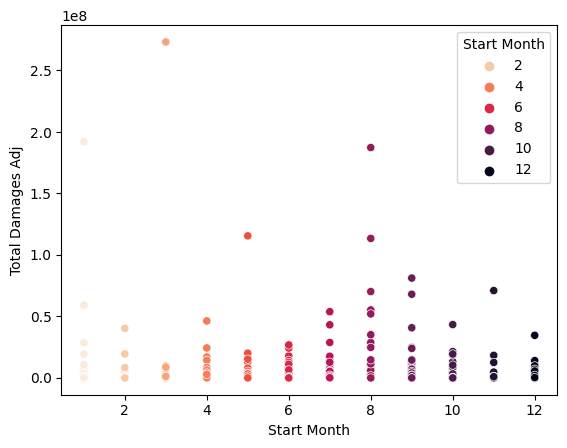

In [67]:
sns.scatterplot(data=df_earthquake, x='Start Month', y='Total Damages Adj', hue='Start Month', palette='rocket_r')

<Axes: xlabel='Start Year', ylabel='Total Damages Adj'>

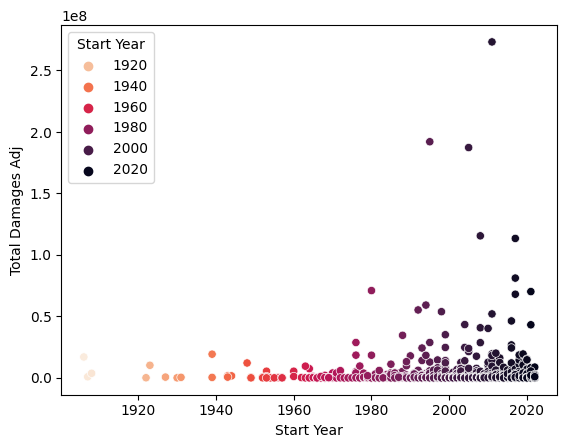

In [68]:
sns.scatterplot(data=df_earthquake, x='Start Year', y='Total Damages Adj', hue='Start Year', palette='rocket_r')

<Axes: xlabel='Total Deaths', ylabel='Total Damages Adj'>

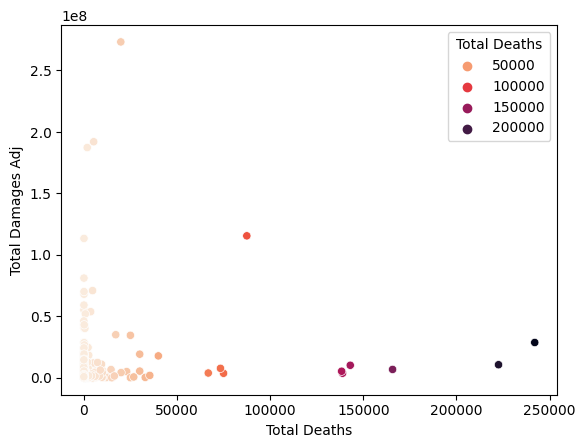

In [69]:
sns.scatterplot(data=df_earthquake, x='Total Deaths', y='Total Damages Adj', hue='Total Deaths', palette='rocket_r')

<Axes: xlabel='Total Affected', ylabel='Total Damages Adj'>

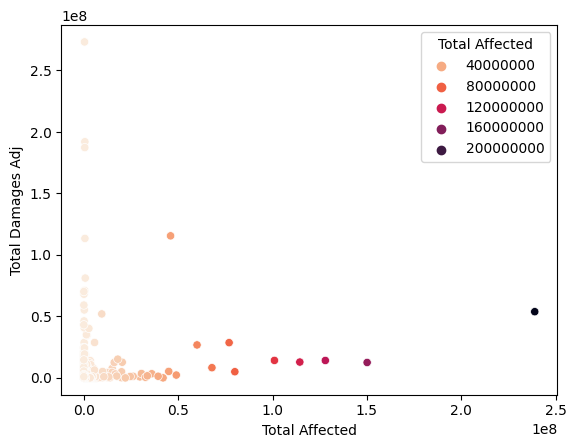

In [70]:
sns.scatterplot(data=df_earthquake, x='Total Affected', y='Total Damages Adj', hue='Total Affected', palette='rocket_r')

* La primera visualización muestra la relación entre 'Dis Mag Value' y 'Total Damages Adj'. Sugiere que existe una fuerte correlación entre estas dos variables, ya que el 'Daños Totales' tiende a aumentar con un 'Valor de Magnitud de Desastre' más alto.
* La segunda visualización muestra la relación entre el 'Mes de inicio' y el 'Daños Totales'. Indica que podría haber alguna variación en el 'Daños Totales' entre diferentes meses, aunque el patrón no está explícitamente claro.
* La tercera visualización representa la relación entre el 'Año de inicio' y el 'Daños Totales'. Sugiere que podría haber algunas tendencias o patrones en el 'Daños Totales' a lo largo de los años, aunque una visión más específica requeriría un análisis más profundo, dado que influye la capacidad de recolección de datos por el incremento y mejora en conocimientos estadísticos e implementación de nuevas tecnologías.
* La cuarta visualización muestra la relación entre 'Muertes Totales' y 'Daños Totales'. Indica que un 'Total de muertes' más alto generalmente corresponde a un 'Daños Totales' más alto.
* La quinta visualización muestra la relación entre 'Total de afectados' y 'Daños Totales'. Sugiere que un 'total afectado' más alto tiende a asociarse con un 'Daños Totales' más alto.

## Preparar X y

In [71]:
X = df_earthquake.select_dtypes(exclude=['object'])  # Excluir columnas categóricas
# X = X.drop('Total Damages Adj', axis=1)  # Quitar 'Total Damages Adj' de X
X = X.drop('Total Damages Adj', axis=1)  # Quitar 'Total Damages Adj' de X
y = df_earthquake['Total Damages Adj']

## train_test_split

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(f"train: {X_train.shape}, {y_train.shape}")
print(f"test: {X_test.shape}, {y_test.shape}")

train: (1381, 11), (1381,)
test: (346, 11), (346,)


# Modelo

## Definir el Modelo

#### Pipeline columnas numéricas

In [73]:
# pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar valores faltantes usando most_frequent
#     ('scaler', StandardScaler()),  # Escalar características numéricas
#     ('classifier', GradientBoostingClassifier()) # Modelo elegido a partir de validación al ser el mejor del ranking
# ])

pipeline_numeric = Pipeline([
    ('impute_median', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])
numeric_col_names = X.select_dtypes(include=np.number).columns.to_list()
numeric_col_names

['Year',
 'Seq',
 'Dis Mag Value',
 'Start Year',
 'Start Month',
 'Start Day',
 'End Year',
 'End Month',
 'End Day',
 'Total Deaths',
 'Total Affected']

#### Pipeline de columnas categóricas

In [74]:
pipeline_categorical = Pipeline([
    ('impute_mostfrequent', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', sparse=False))
])
categorical_col_names = X.select_dtypes(include='object').columns.to_list()
categorical_col_names

[]

#### Pipeline numéricas + categóricas

In [75]:
preprocessor = ColumnTransformer([
    ('numerical', pipeline_numeric, numeric_col_names),
    ('categorical', pipeline_categorical, categorical_col_names)
])
preprocessor

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('impute_median',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Year', 'Seq', 'Dis Mag Value', 'Start Year',
                                  'Start Month', 'Start Day', 'End Year',
                                  'End Month', 'End Day', 'Total Deaths',
                                  'Total Affected']),
                                ('categorical',
                                 Pipeline(steps=[('impute_mostfrequent',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 [])])

## Pipeline numéricas + categóricas + modelado

In [76]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    # ('classifier', RandomForestRegressor()) # se puede cambiar el algoritmo
    ('regressor', RandomForestRegressor())
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('impute_median',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Year', 'Seq',
                                                   'Dis Mag Value',
                                                   'Start Year', 'Start Month',
                                                   'Start Day', 'End Year',
                                                   'End Month', 'End Day',
                                                   'Total Deaths',
                                                   'Total Affected']),
                                                 ('categorical',
                                                  Pipeline(steps=[('impute_mostfrequent',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  [])])),
                ('regressor', RandomForestRegressor())])

## Ejecución de pipeline

### Entrenar el modelo

In [77]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('impute_median',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Year', 'Seq',
                                                   'Dis Mag Value',
                                                   'Start Year', 'Start Month',
                                                   'Start Day', 'End Year',
                                                   'End Month', 'End Day',
                                                   'Total Deaths',
                                                   'Total Affected']),
                                                 ('categorical',
                                                  Pipeline(steps=[('impute_mostfrequent',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  [])])),
                ('regressor', RandomForestRegressor())])

#### Explicación de pipeline:
pipeline_numeric: Esta es una subcanalización para procesar características numéricas. Consiste en dos pasos:

* impute_median: Utiliza el SimpleImputer con el parámetrostrategy='median' para llenar los valores que faltan en las columnas numéricas con sus valores medianos.
* scaler: el MinMaxScaler se aplica para escalar las características numéricas a un rango entre 0 y 1, conservando las relaciones relativas entre los puntos de datos.
* numeric_col_names: esta es una lista de nombres de columnas que contienen características numéricas. El método select_dtypes(include=np.number) selecciona todas las columnas con tipos de datos numéricos (por ejemplo, int64, float64), y column.to_list() las convierte en una lista.

2. pipeline_categorical: este es un canal secundario para procesar características categóricas. Consiste en dos pasos:

* impute_mostfrequent: Utiliza el SimpleImputer con la estrategia = 'most_frequent' para completar los valores faltantes en las columnas categóricas con la categoría (modo) más frecuente.
* codificador: el OneHotEncoder se usa para codificar en caliente las características categóricas, creando columnas binarias para cada categoría. El parámetro drop='first' elimina la primera columna codificada para evitar la multicolinealidad y sparse=False devuelve una matriz densa en lugar de una matriz dispersa.
* categorical_col_names: esta es una lista de nombres de columnas que contienen características categóricas. El método select_dtypes(include='object') selecciona todas las columnas con el tipo de datos del objeto (por ejemplo, cadena, categoría), y column.to_list() las convierte en una lista.

3. preprocessor: el ColumnTransformer se usa para aplicar las transformaciones especificadas a diferentes subconjuntos de los datos. Combina los subcanales numéricos y categóricos:

* 'numerical': aplica el pipeline_numeric a las columnas especificadas en numeric_col_names.
* 'categorical': aplica el pipeline_categorical a las columnas especificadas en categorical_col_names.

4. pipeline: esta es la arquitectura de procesamiento final que combina el preprocesador con el clasificador (RandomForestRegressor). Consiste en dos pasos:

* 'preprocessor': aplica el preprocesador (que incluye procesamiento tanto numérico como categórico) a los datos de entrada.
* 'classifier': utiliza RandomForestRegressor como paso final para realizar la tarea de clasificación. 

El modelo puede reemplazarse por otros como:

RandomForestRegressor: adecuado para relaciones no lineales entre entidades y la variable de destino. Puede manejar bien los datos faltantes y los valores atípicos y proporciona un buen rendimiento predictivo en muchos casos.

Red neuronal: para gran cantidad de datos y patrones complejos. Los modelos de aprendizaje profundo pueden capturar patrones y relaciones complejos en los datos, pero pueden requerir más datos y recursos computacionales.

Support Vector Regressor (SVR): efectivo para tratar con datos de alta dimensión y relaciones no lineales.

XGBoost Regressor: esta es una popular biblioteca de aumento de gradiente conocida por su alto rendimiento y eficiencia en el manejo de grandes conjuntos de datos.

En general, este pipeline está diseñado para manejar características numéricas y categóricas por separado. Las características numéricas se imputan con sus valores medianos y luego se escalan usando MinMaxScaler. Las características categóricas se imputan con sus valores más frecuentes y luego se codifican one-hot. Finalmente, las características preprocesadas se introducen en el clasificador elegido para la tarea de clasificación.

## Ejecución de pipeline

In [78]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

## Guardar pipeline

Se usa joblib para guardar modelos o pipelines.

Serializa un modelo o pipeline (objeto Python) a una secuencia de bytes que se almacenan en un archivo

* joblib.dump()
* joblib.load()

In [79]:
# pickle .pkl o .joblib
joblib.dump(pipeline, 'pipelineGBC_Earthquake_TotalDamages.pkl') # más genérico
joblib.dump(pipeline, 'pipelineGBC_Earthquake_TotalDamages.joblib') # más eficiente con muchos datos

['pipelineGBC_Earthquake_TotalDamages.joblib']

## Cargar pipeline

In [80]:
pipeline = joblib.load('pipelineGBC_Earthquake_TotalDamages.joblib')
pipeline.predict(X_test)[:10]

array([ 741030.02,  282833.83,   72371.71, 2054090.84, 1712747.74,
        760567.41, 1440947.64, 1156408.74, 1242921.28,  870493.42])

# Evaluar Modelo

### Predicción y_pred

In [81]:
y_pred = pipeline.predict(X_test)

In [82]:
y_pred.shape

(346,)

# Últimas comprobaciones dataframe

In [83]:
df_earthquake.head(100)

,Dis No,Year,Seq,Disaster Subgroup,Disaster Type,Disaster Subtype,Country,ISO,Region,Continent,...,Longitude,Start Year,Start Month,Start Day,End Year,End Month,End Day,Total Deaths,Total Affected,Total Damages Adj
64,1922-0011-CAN,1922,11,Climatological,Wildfire,Forest fire,Canada,CAN,Northern America,Americas,...,NaN,1922,9,30,1922,9,30,43,11000,139559
135,1939-0001-CHL,1939,1,Geophysical,Earthquake,Ground movement,Chile,CHL,South America,Americas,...,-72.315,1939,1,24,1939,1,24,30000,58500,19312844
151,1943-0010-CHL,1943,10,Geophysical,Earthquake,Ground movement,Chile,CHL,South America,Americas,...,-71.475,1943,4,6,1943,4,6,12,35,1687452
158,1944-0002-ARG,1944,2,Geophysical,Earthquake,Ground movement,Argentina,ARG,South America,Americas,...,68.436,1944,1,15,1944,1,15,10000,155000,1658743
184,1949-0010-ECU,1949,10,Geophysical,Earthquake,Ground movement,Ecuador,ECU,South America,Americas,...,-78.2,1949,8,5,1949,8,5,6000,100000,245448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1796,1977-0078-TON,1977,78,Geophysical,Earthquake,Ground movement,Tonga,TON,Polynesia,Oceania,...,-175.9,1977,6,23,1977,6,23,1,5505,5794
1814,1978-0115-IRN,1978,115,Geophysical,Earthquake,Ground movement,Iran (Islamic Republic of),IRN,Southern Asia,Asia,...,57.434,1978,9,16,1978,9,16,25000,40000,224314
1818,1978-0080-JPN,1978,80,Geophysical,Earthquake,Ground movement,Japan,JPN,Eastern Asia,Asia,...,142.028,1978,6,12,1978,6,12,28,2500,3880630
1830,1978-0040-MOZ,1978,40,Hydrological,Flood,NaN,Mozambique,MOZ,Eastern Africa,Africa,...,NaN,1978,3,0,1978,3,0,40,200000,282635


In [84]:
df_earthquake.columns

Index(['Dis No', 'Year', 'Seq', 'Disaster Subgroup', 'Disaster Type',
       'Disaster Subtype', 'Country', 'ISO', 'Region', 'Continent', 'Location',
       'Origin', 'Associated Dis', 'Dis Mag Value', 'Dis Mag Scale',
       'Latitude', 'Longitude', 'Start Year', 'Start Month', 'Start Day',
       'End Year', 'End Month', 'End Day', 'Total Deaths', 'Total Affected',
       'Total Damages Adj'],
      dtype='object')

In [85]:
df_earthquake.isnull().sum()

Dis No                  0
Year                    0
Seq                     0
Disaster Subgroup       0
Disaster Type           0
Disaster Subtype      103
Country                 0
ISO                     0
Region                  0
Continent               0
Location               28
Origin               1120
Associated Dis       1056
Dis Mag Value           0
Dis Mag Scale           4
Latitude              970
Longitude             970
Start Year              0
Start Month             0
Start Day               0
End Year                0
End Month               0
End Day                 0
Total Deaths            0
Total Affected          0
Total Damages Adj       0
dtype: int64

In [86]:
df_earthquake['Total Damages Adj'].min()

2

In [87]:
df_earthquake['Total Damages Adj'].unique()

array([  139559, 19312844,  1687452, ...,    50000,   250000,  1000000],
      dtype=int64)

### Pivot Tables

In [88]:
# df_earthquakeresult_pivot_table = pd.pivot_table(df_earthquake, index='Total Damages Adj', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='min')
# df_earthquakeresult_pivot_table

In [89]:
# df_floodresult_pivot_table = pd.pivot_table(df_earthquake, index='Total Damages Adj', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='max')
# df_earthquakeresult_pivot_table

In [90]:
# df_earthquakeresult_pivot_table = pd.pivot_table(df_earthquake, index='Total Damages Adj', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='sum')
# df_earthquakeresult_pivot_table

In [91]:
# df_earthquakeresult_pivot_table = pd.pivot_table(df_earthquake, index='Total Damages Adj', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='mean')
# df_earthquakeresult_pivot_table

In [92]:
# df_earthquakeresult_pivot_table = pd.pivot_table(df_earthquake, index='Total Damages Adj', values=['Dis Mag Value', 'Total Deaths', 'Total Affected', 'Total Damages Adj'], aggfunc='median')
# df_earthquakeresult_pivot_table

# Reporte de Clasificación

La precisión, la recuperación y la puntuación F1 son métricas de evaluación de uso común en modelos de aprendizaje automático, particularmente en tareas de clasificación. Estas métricas brindan información sobre el rendimiento del modelo y su capacidad para clasificar correctamente las instancias.

* Precision: la precisión mide la proporción de instancias positivas pronosticadas correctamente (positivos verdaderos) de todas las instancias pronosticadas como positivas (positivos verdaderos + positivos falsos). En otras palabras, la precisión indica qué tan preciso o exacto es el modelo cuando predice una clase positiva. Una puntuación de alta precisión sugiere que el modelo tiene una baja tasa de falsos positivos.

* Recall: la recuperación, también conocida como sensibilidad o tasa de verdaderos positivos, mide la proporción de instancias positivas pronosticadas correctamente (verdaderos positivos) de todas las instancias positivas reales (verdaderos positivos + falsos negativos). Representa la capacidad del modelo para identificar o capturar instancias positivas. Una puntuación de recuerdo alta sugiere que el modelo tiene una tasa baja de falsos negativos.

* f1-score: La puntuación F1 es la media armónica de precisión y recuperación. Proporciona una medida equilibrada que considera simultáneamente la precisión y la recuperación. La puntuación F1 combina precisión y recuperación en una sola métrica y proporciona una evaluación más completa del rendimiento del modelo. Es especialmente útil cuando se trata de conjuntos de datos desequilibrados, donde la distribución de clases es desigual.

Al interpretar estas métricas, es fundamental tener en cuenta los objetivos y requisitos específicos de la tarea de clasificación. Es deseable una puntuación de alta precisión cuando es crucial minimizar los falsos positivos. Por otro lado, una puntuación alta de recuerdo es deseable cuando la captura de tantos positivos verdaderos como sea posible es una prioridad. La puntuación F1 proporciona una vista equilibrada, teniendo en cuenta tanto la precisión como la recuperación.

En resumen, la precisión, la recuperación y la puntuación F1 son métricas valiosas para evaluar el rendimiento de un modelo de clasificación, que brindan información sobre su precisión, capacidad para capturar instancias positivas y rendimiento general equilibrado.

In [93]:
report = classification_report(y_test, y_pred)
print("Reporte de Clasificación:")
print(report)

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

Resultados de reporte de clasificación

Según el informe de clasificación, el modelo parece funcionar bien, logrando una alta precisión, recuperación y puntuación F1 para cada clase. La alta precisión sugiere que el modelo es capaz de predecir el 'Daños Totales' con un alto grado de corrección. Sin embargo, es importante tener en cuenta que sería necesario un mayor análisis y consideración de otras métricas de evaluación, como la validación cruzada o la validación de datos no vistos, para obtener una evaluación integral del rendimiento del modelo.

#### Interpretación de primer Reporte de Clasificación con RandomForestRegressor:

### Evaluación con mae, rmse y r2

In [94]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("Coefficient of Determination (R^2):", r2)

Mean Absolute Error (MAE): 3992270.6176878614
Root Mean Squared Error (RMSE): 18073010.878399298
Coefficient of Determination (R^2): -0.3028593628842242


Los resultados son demasiado altos, por tanto, no funciona el modelo o el preprocesamiento:
* Mean Absolute Error (MAE): 3992270.6176878614
* Root Mean Squared Error (RMSE): 18073010.878399298
* Coefficient of Determination (R^2): -0.3028593628842242

#### Resultados de mae, rmse y r2 con GradientBoosterClassifier

Interpretación de las métricas de rendimiento:

* Error absoluto medio (MAE): 1748927.015625

El error absoluto medio (MAE) mide la diferencia absoluta promedio entre los valores predichos y los valores reales. En este caso, el MAE es de aproximadamente 1.748.927. Esto significa que, en promedio, las predicciones del modelo están desviadas en aproximadamente 1.748.927 unidades de los valores reales. Un MAE más bajo indica un mejor rendimiento, ya que representa menos error de predicción.


* Error cuadrático medio (RMSE): 12581576.452120619

El error cuadrático medio (RMSE) es otra medida del error de predicción, tomando la raíz cuadrada del promedio de las diferencias al cuadrado entre los valores predichos y reales. En este caso, el RMSE es de aproximadamente 12.581.576. Esto significa que, en promedio, las predicciones del modelo están desviadas en aproximadamente 12 581 576 unidades de los valores reales. Al igual que MAE, un RMSE más bajo indica un mejor rendimiento.


* Coeficiente de Determinación (R^2): -7.382393519518141

El coeficiente de determinación, indicado como R^2, es una medida de qué tan bien el modelo explica la varianza en la variable dependiente (la variable objetivo). R^2 varía de infinito negativo a 1, donde 1 indica un ajuste perfecto y los valores cercanos a 1 indican un mejor ajuste. En este caso, el R^2 es negativo (-7.38), lo cual es inusual e indica que el modelo está funcionando mal y peor que una simple línea horizontal (predicción media). R^2 negativo sugiere que el modelo no está capturando la varianza en la variable de destino y está funcionando peor que una predicción promedio básica.

El informe de clasificación proporciona métricas de evaluación para el modelo RandomForestRegressor.
La precisión, el recuerdo (recall) y la puntuación F1 (f1-score) se informan para cada clase (1, 2, 3, 4), junto con el soporte (número de muestras) para cada clase.
También se informa la precisión del modelo: 1, lo que indica la corrección general de las predicciones.
Las métricas de macro avg o macropromedio y weighted avg o promedio ponderado proporcionan medidas de rendimiento agregadas en todas las clases.

# Conclusiones del modelo Earthquake RandomForestRegressor

Se aplicó previamente GradientBoostingClassifier y se canceló, ya que duraba demasiado tiempo.
RandomForestRegressor tampoco es capaz de para predecir Total Damages Adj, como lo indican los altísimos valores de MAE y RMSE y el valor alto de R-cuadrado. Esto puede deberse a que existen demasiados niveles por determinar, ya que, a diferencia de Flood donde hay 4 niveles, en este caso hay 6.

Las métricas de rendimiento proporcionadas indican que las predicciones del modelo no son precisas y tienen un rendimiento muy deficiente para explicar la variación en la variable de destino. Tanto el MAE como el RMSE son bastante altos, lo que indica errores de predicción significativos. Además, el R^2 negativo indica que el modelo no captura ningún patrón o relación en los datos, y sus predicciones son peores que una predicción promedio básica.

Esto sugiere que el modelo puede no ser adecuado para los datos o que hay problemas con el preprocesamiento, las características o el proceso de entrenamiento del modelo que deben abordarse para mejorar su rendimiento. Es posible que sea necesario realizar más análisis y ajustes al modelo para lograr mejores resultados predictivos.

# Recomendaciones